## ライブラリのインポート
missingno : 欠損値可視化用ライブラリ  
参考リンク : [欠損値の出現パターンを簡単に可視化する](https://qiita.com/TomoyukiAota/items/fd75c28b802bad9e6632)  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import StratifiedKFold,GridSearchCV
# 欠損値の可視化用ライブラリ
import missingno as mssno

seed =45

## データ確認

In [81]:
path = 'csv/'
train = pd.read_csv(path+'train.csv', na_values=-1)
test = pd.read_csv(path+'test.csv', na_values=-1)
print('Number rows and columns:', train.shape)
print('Number rows and columns:', test.shape)

Number rows and columns: (595212, 59)
Number rows and columns: (892816, 58)


In [82]:
# pandas.DataFrameの行と列を入れ替える（転置）
# train.head(3).T

0    573518
1     21694
Name: target, dtype: int64

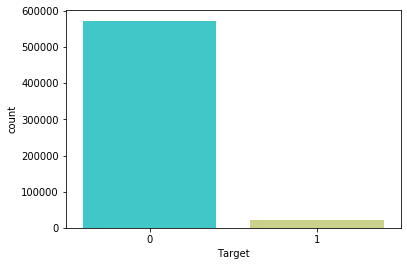

In [83]:
plt.figure()
sns.countplot(train['target'], palette='rainbow')
plt.xlabel('Target')

train['target'].value_counts()

targetにはかなりの偏りがある。  
0 : 573518  
1 : 21694  
なので0の数は1の数の25倍ほどである。  

## 相関関係の描画
- pd.DataFrame.corr()  
    - 1つのDataFrameに含まれるデータの相関係数を総当たりで算出  
- seaborn.heatmap()  
    - ヒートマップを可視化  

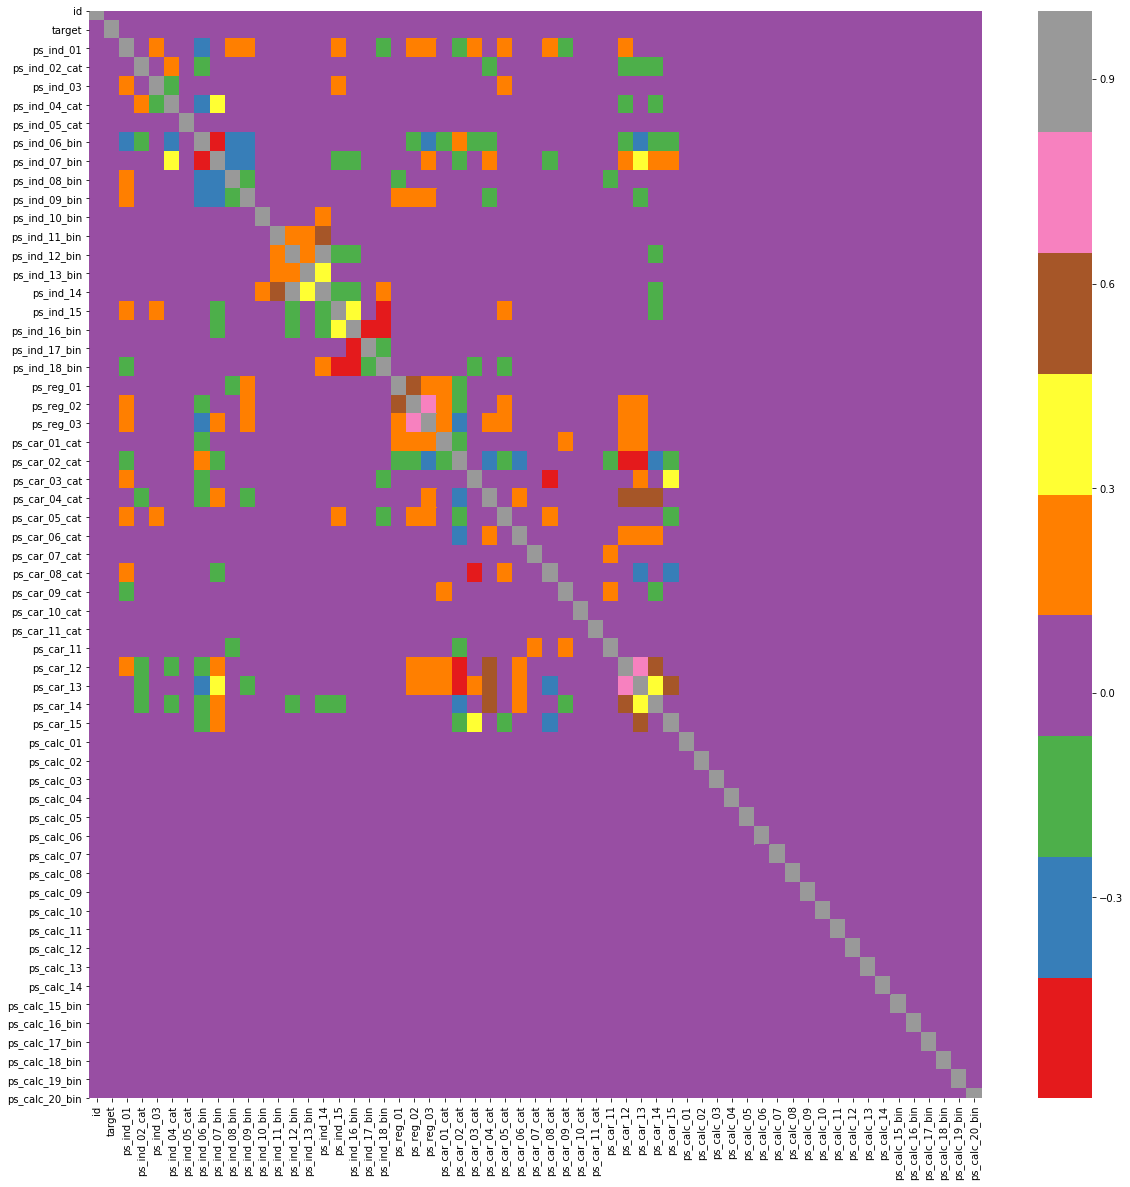

In [84]:
cor = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor, cmap='Set1')

ps_calcの相関が全て0なので学習に与える影響がないとして、データセットから消去  
axis=0 が行、axis=1 が列

- str.startswith()  
    - 特定の文字で始まる行を抽出  

[pandasで特定の文字列を含む行を抽出（完全一致、部分一致）](https://note.nkmk.me/python-pandas-str-contains-match/)  

In [85]:
ps_cal = train.columns[train.columns.str.startswith('ps_calc')] 
train = train.drop(ps_cal, axis =1)
test = test.drop(ps_cal, axis=1)
train.shape

(595212, 39)

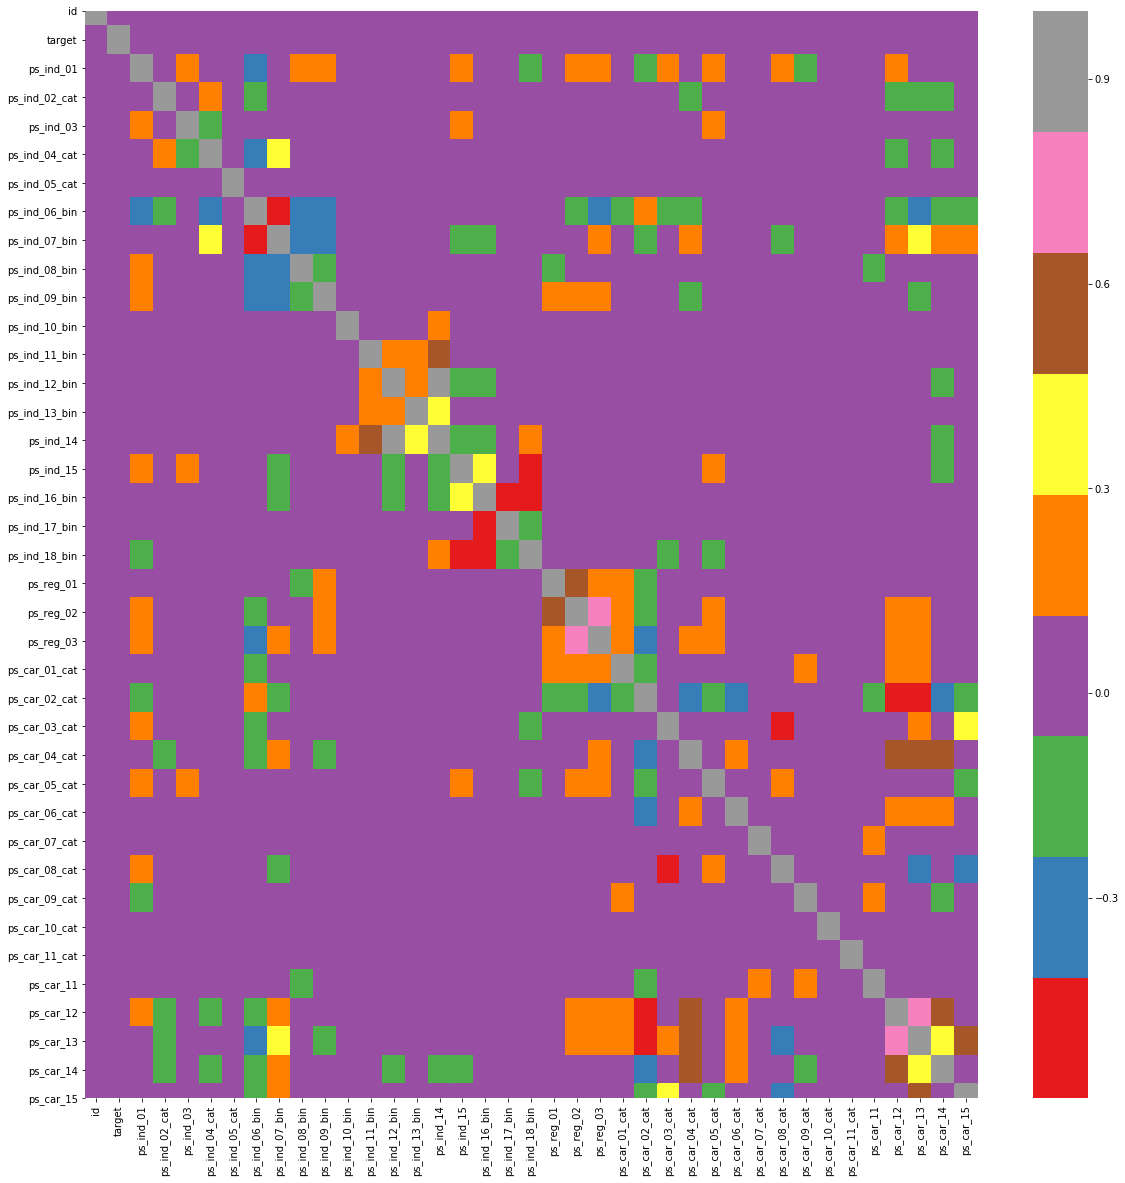

In [86]:
# 再度ヒートマップを確認
cor = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor, cmap='Set1')

## 欠損データの確認

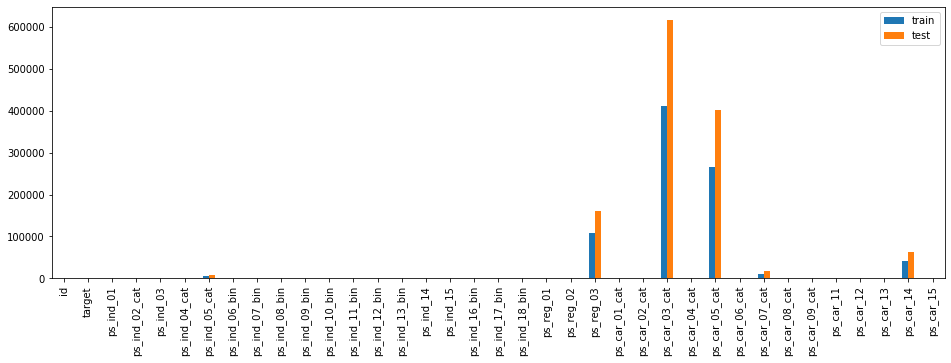

In [35]:
k= pd.DataFrame()
k['train']= train.isnull().sum()
k['test'] = test.isnull().sum()
fig,ax = plt.subplots(figsize=(16, 5))
k.plot(kind='bar', ax=ax)

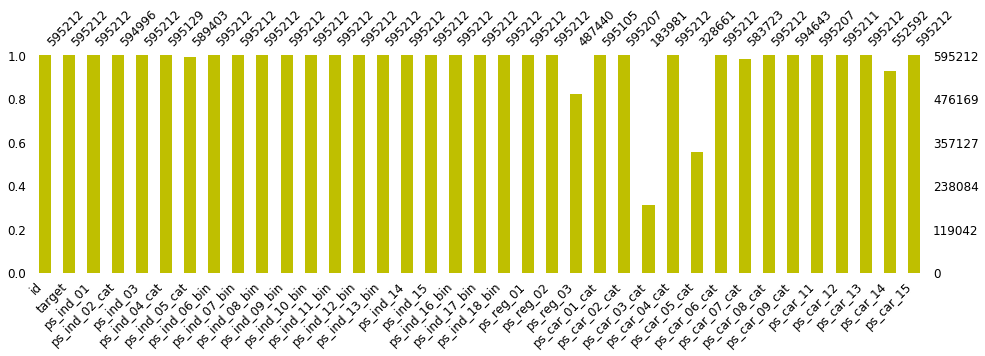

In [36]:
mssno.bar(train,color='y',figsize=(16,4),fontsize=12)

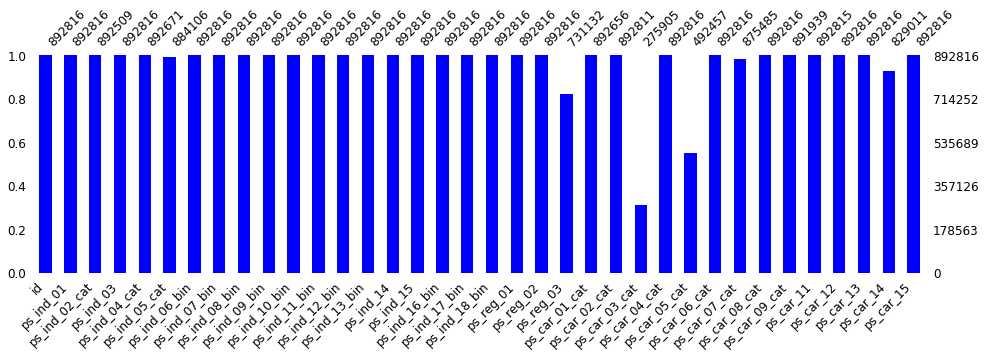

In [37]:
mssno.bar(test,color='b',figsize=(16,4),fontsize=12)

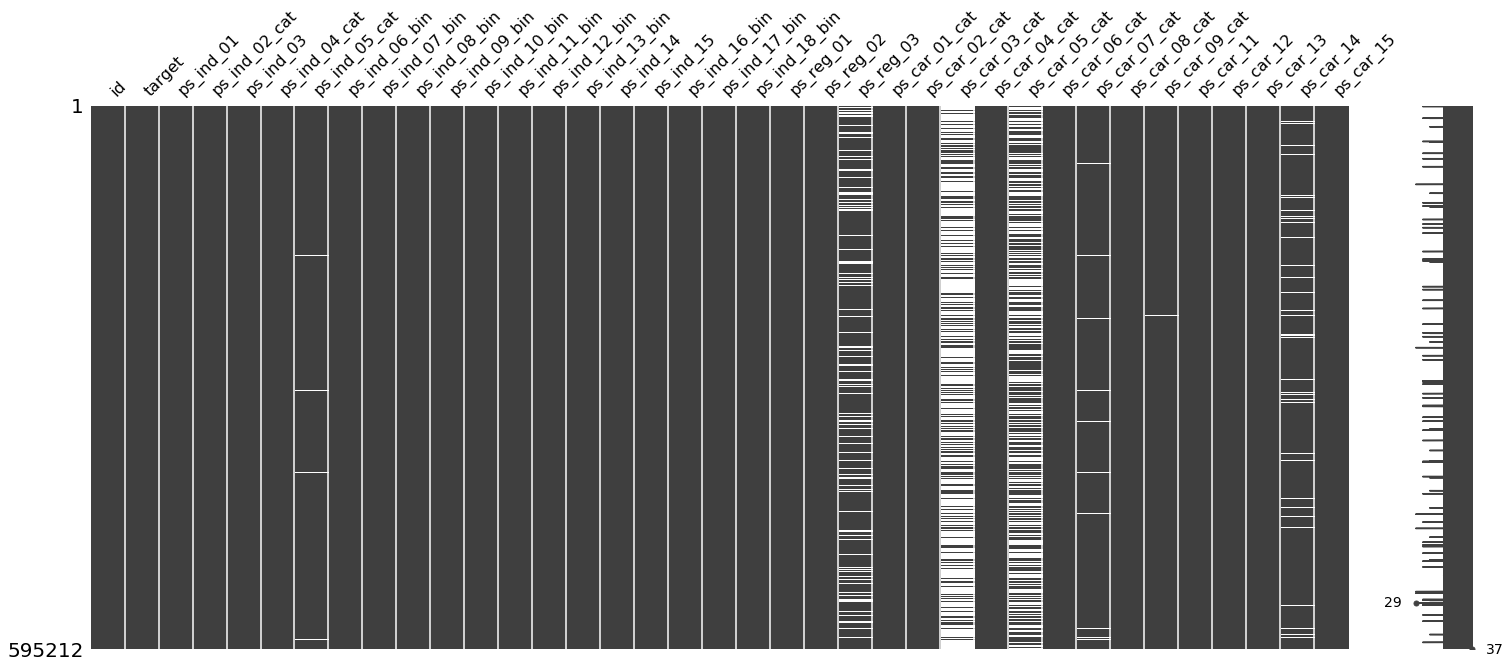

In [38]:
mssno.matrix(train)

### 欠損値をmodeで補完
mode : 最頻値  

- mode()  
    - index番号に紐づくobject型で返されるので[0]を指定する必要あり  
    - inplace=True　にしないともとのDFに反映されない  

In [87]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [88]:
missing_value(train)
missing_value(test)

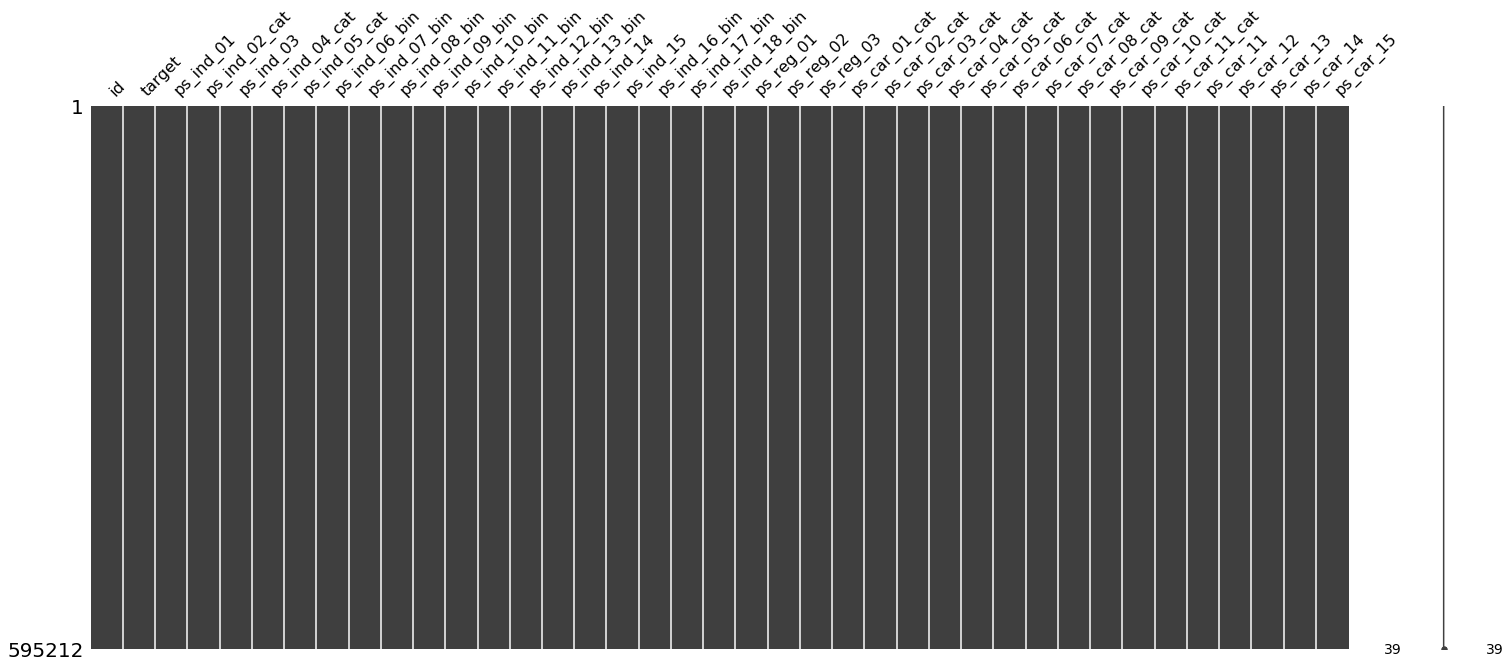

In [89]:
mssno.matrix(train)

## Convert variables into category type

- nunique()  
    - ユニークな要素の個数をintで返す  
- dtype()  
    - データ型を表示  

In [42]:
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(train)

,Missing value,N unique value,dtype
id,0,595212,int64
target,0,2,int64
ps_ind_01,0,8,int64
ps_ind_02_cat,0,4,float64
ps_ind_03,0,12,int64
ps_ind_04_cat,0,2,float64
ps_ind_05_cat,0,7,float64
ps_ind_06_bin,0,2,int64
ps_ind_07_bin,0,2,int64
ps_ind_08_bin,0,2,int64


In [43]:
def category_type(df):
    col = df.columns
    for i in col:
        if df[i].nunique()<=104:
            df[i] = df[i].astype('category')
category_type(train)
category_type(test)

## Univariate analysis

In [44]:
cat_col = [col for col in train.columns if '_cat' in col]
print(cat_col)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat']


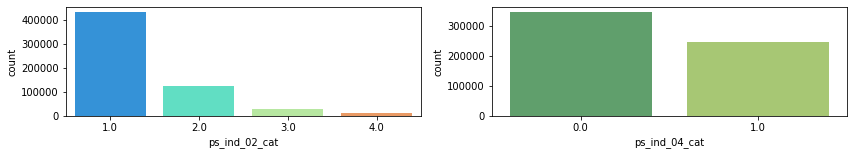

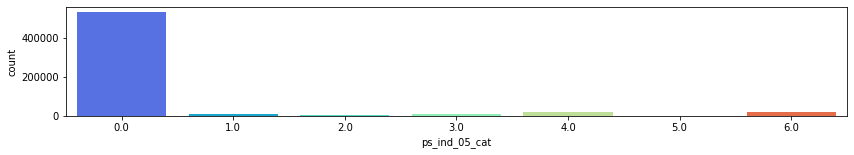

In [45]:
fig ,ax = plt.subplots(1,2,figsize=(14,2))
ax1,ax2, = ax.flatten()
sns.countplot(train['ps_ind_02_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_ind_04_cat'],palette='summer',ax=ax2)
fig,ax = plt.subplots(figsize=(14,2))
sns.countplot(train['ps_ind_05_cat'],palette='rainbow',ax=ax)

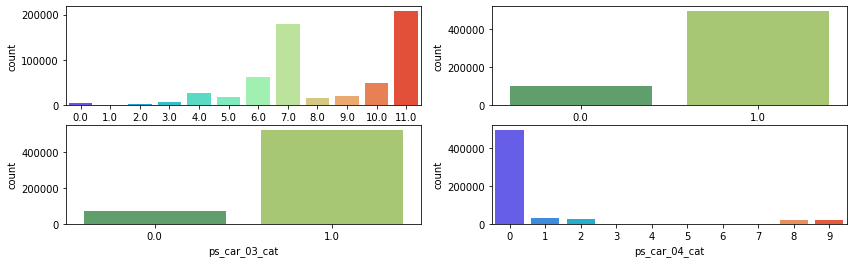

In [46]:
fig,ax = plt.subplots(2,2,figsize=(14,4))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_01_cat'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_car_02_cat'],palette='summer',ax=ax2)
sns.countplot(train['ps_car_03_cat'],palette='summer',ax=ax3)
sns.countplot(train['ps_car_04_cat'],palette='rainbow',ax=ax4)

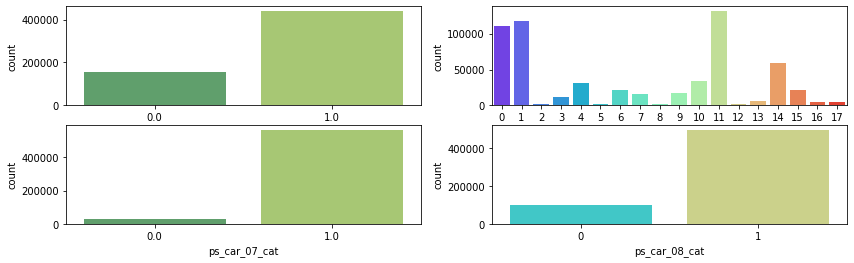

In [47]:
fig,ax = plt.subplots(2,2,figsize = (14,4))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(train['ps_car_05_cat'],palette='summer',ax=ax1)
sns.countplot(train['ps_car_06_cat'],palette='rainbow',ax=ax2)
sns.countplot(train['ps_car_07_cat'],palette='summer',ax=ax3)
sns.countplot(train['ps_car_08_cat'],palette='rainbow',ax=ax4)

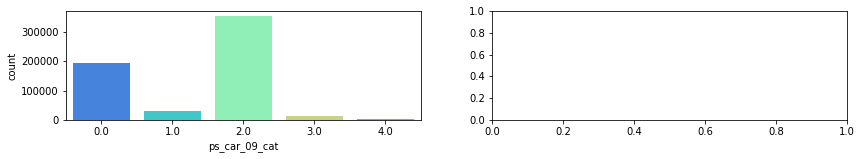

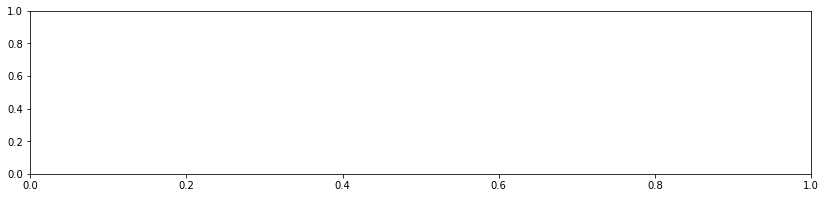

In [50]:
fig, ax = plt.subplots(1,2,figsize=(14,2))
ax1,ax2 = ax.flatten()
sns.countplot(train['ps_car_09_cat'],palette='rainbow',ax=ax1)
#sns.countplot(train['ps_car_10_cat'],palette='gist_rainbow',ax=ax2)
fig,ax = plt.subplots(figsize=(14,3))
#sns.countplot(train['ps_car_11_cat'],palette='rainbow',ax=ax)

In [51]:
bin_col = [col for col in train.columns if 'bin' in col]
print(bin_col)

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


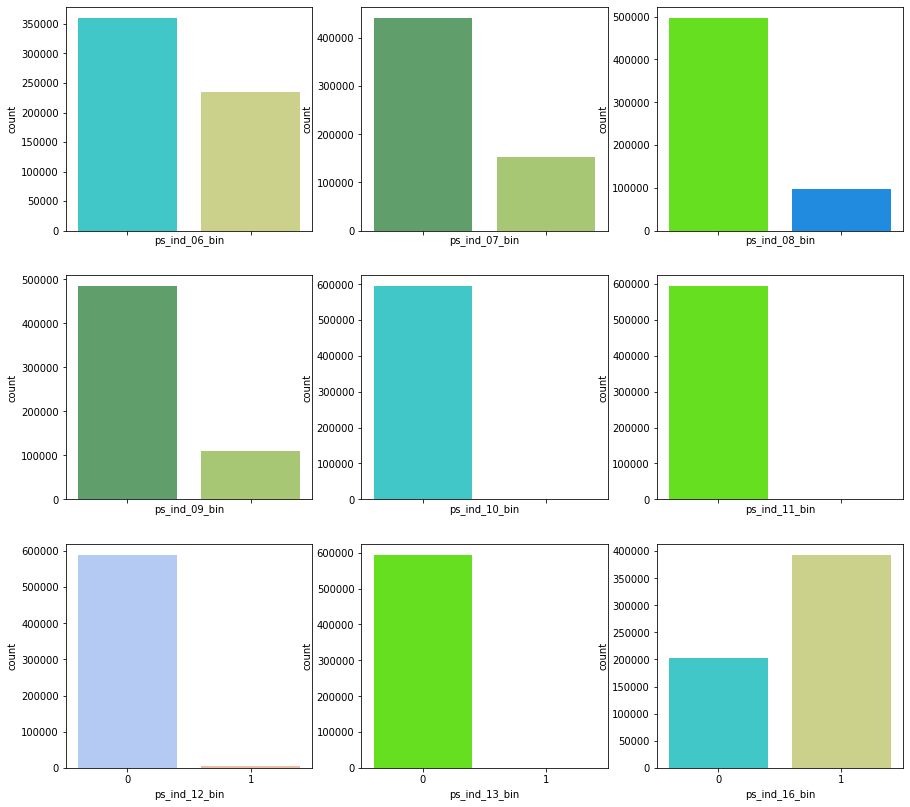

In [52]:
fig,ax = plt.subplots(3,3,figsize=(15,14),sharex='all')
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9 = ax.flatten()
sns.countplot(train['ps_ind_06_bin'],palette='rainbow',ax=ax1)
sns.countplot(train['ps_ind_07_bin'],palette='summer',ax=ax2)
sns.countplot(train['ps_ind_08_bin'],palette='gist_rainbow',ax=ax3)
sns.countplot(train['ps_ind_09_bin'],palette='summer',ax=ax4)
sns.countplot(train['ps_ind_10_bin'],palette='rainbow',ax=ax5)
sns.countplot(train['ps_ind_11_bin'],palette='gist_rainbow',ax=ax6)
sns.countplot(train['ps_ind_12_bin'],palette='coolwarm',ax=ax7)
sns.countplot(train['ps_ind_13_bin'],palette='gist_rainbow',ax=ax8)
sns.countplot(train['ps_ind_16_bin'],palette='rainbow',ax=ax9)

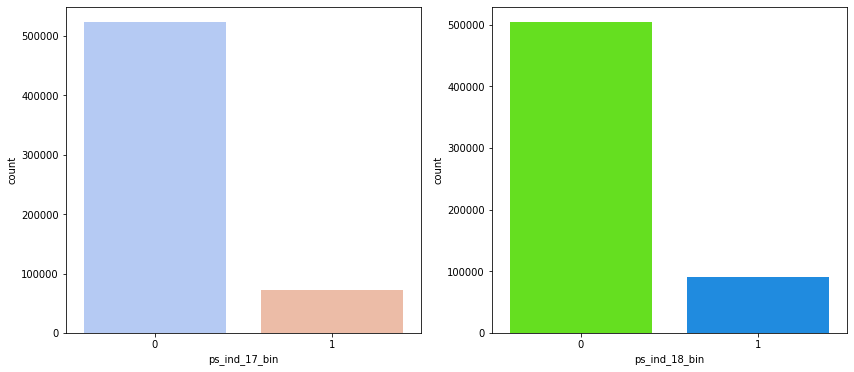

In [53]:
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax1,ax2 = ax.flatten()
sns.countplot(train['ps_ind_17_bin'],palette='coolwarm',ax=ax1)
sns.countplot(train['ps_ind_18_bin'],palette='gist_rainbow',ax=ax2)

In [54]:
tot_cat_col = list(train.select_dtypes(include=['category']).columns)

other_cat_col = [c for c in tot_cat_col if c not in cat_col+ bin_col]
other_cat_col

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15']

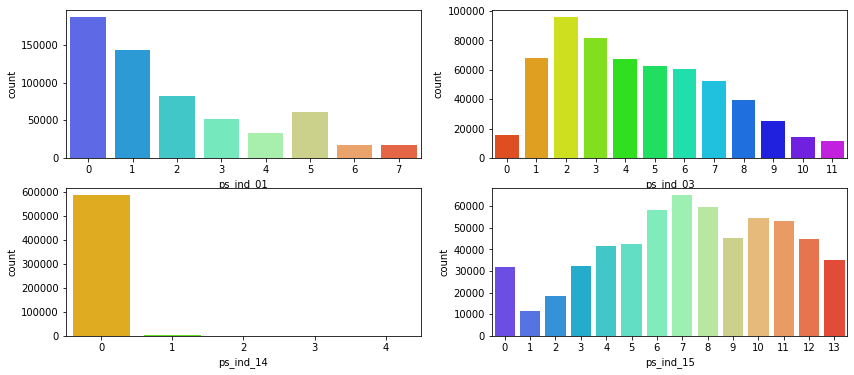

In [55]:
fig,ax = plt.subplots(2,2,figsize=(14,6))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.countplot(data=train,x='ps_ind_01',palette='rainbow',ax=ax1)
sns.countplot(data=train,x='ps_ind_03',palette='gist_rainbow',ax=ax2)
sns.countplot(data=train,x='ps_ind_14',palette='gist_rainbow',ax=ax3)
sns.countplot(data=train,x='ps_ind_15',palette='rainbow',ax=ax4)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

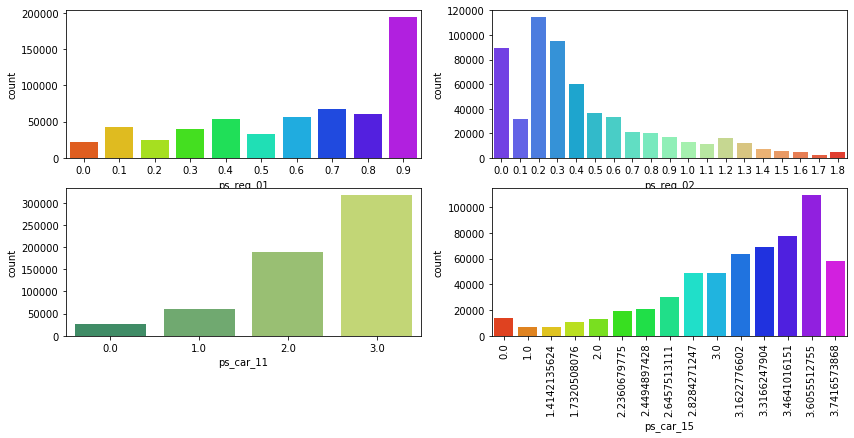

In [56]:
fig,ax = plt.subplots(2,2,figsize=(14,6))
ax1,ax2,ax3,ax4 =ax.flatten()
sns.countplot(data=train,x='ps_reg_01',palette='gist_rainbow',ax=ax1)
sns.countplot(data=train,x='ps_reg_02',palette='rainbow',ax=ax2)
sns.countplot(data=train,x='ps_car_11',palette='summer',ax=ax3)
sns.countplot(data=train,x='ps_car_15',palette='gist_rainbow',ax=ax4)
plt.xticks(rotation=90)

In [57]:
num_col = [c for c in train.columns if c not in tot_cat_col]
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [58]:
train['ps_reg_03'].describe()

count    595212.000000
mean          0.846950
std           0.328237
min           0.061237
25%           0.633936
50%           0.720677
75%           1.000000
max           4.037945
Name: ps_reg_03, dtype: float64

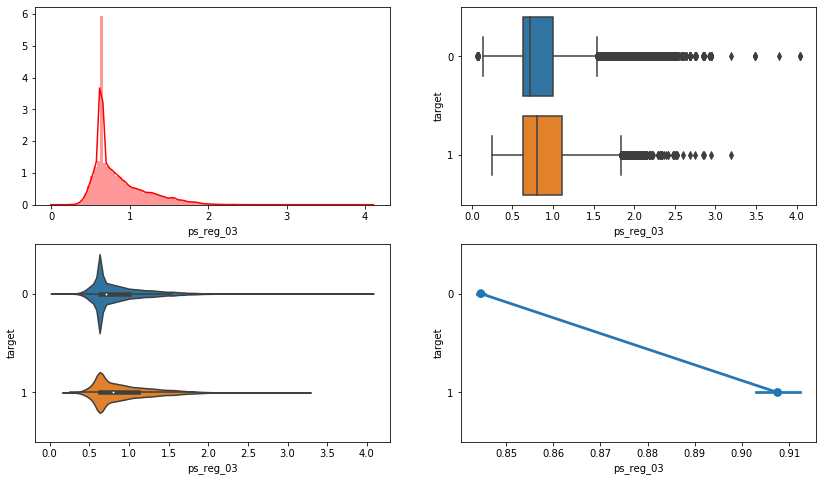

In [59]:
fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['ps_reg_03'],bins=100,color='red',ax=ax1)
sns.boxplot(x ='ps_reg_03',y='target',data=train,ax=ax2)
sns.violinplot(x ='ps_reg_03',y='target',data=train,ax=ax3)
sns.pointplot(x= 'ps_reg_03',y='target',data=train,ax=ax4)

In [60]:
train['ps_car_12'].describe()

count    595212.000000
mean          0.379947
std           0.058300
min           0.100000
25%           0.316228
50%           0.374166
75%           0.400000
max           1.264911
Name: ps_car_12, dtype: float64

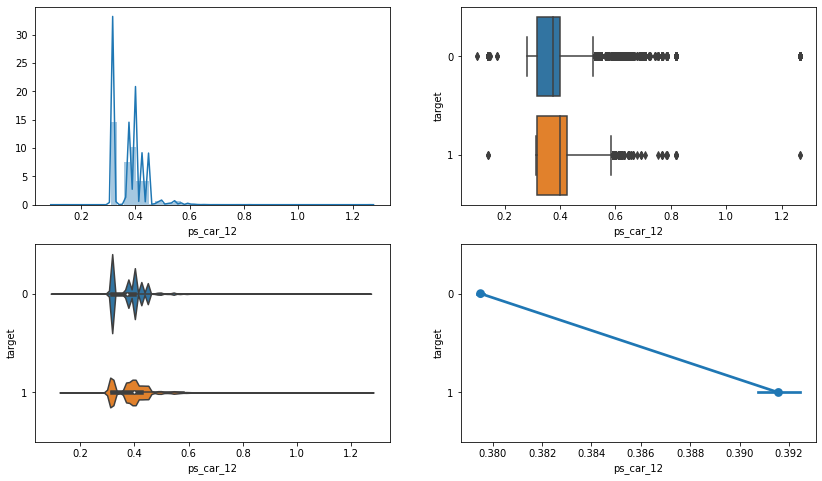

In [61]:
fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['ps_car_12'],bins=50,ax=ax1)
sns.boxplot(x='ps_car_12',y='target',data=train,ax=ax2)
sns.violinplot(x='ps_car_12',y='target',data=train,ax=ax3)
sns.pointplot(x='ps_car_12',y='target',data=train,ax=ax4)

In [62]:
train['ps_car_13'].describe()

count    595212.000000
mean          0.813265
std           0.224588
min           0.250619
25%           0.670867
50%           0.765811
75%           0.906190
max           3.720626
Name: ps_car_13, dtype: float64

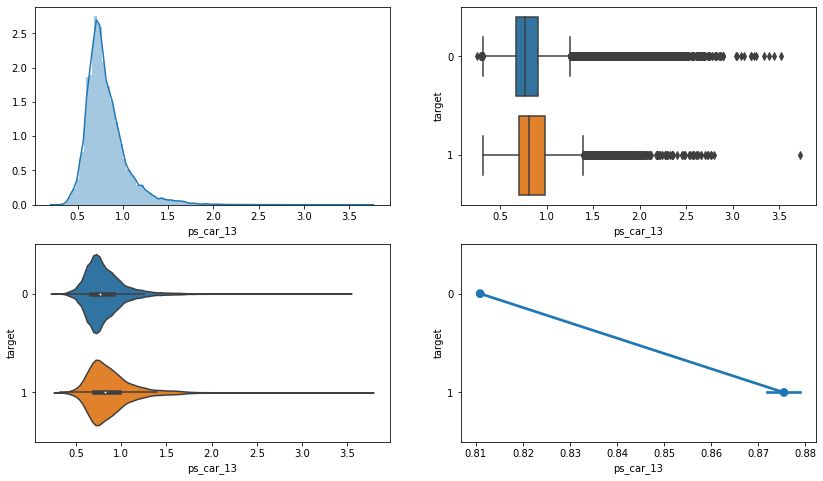

In [63]:
fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['ps_car_13'],bins=120,ax=ax1)
sns.boxplot(x='ps_car_13',y='target',data=train,ax=ax2)
sns.violinplot(x='ps_car_13',y='target',data=train,ax=ax3)
sns.pointplot(x='ps_car_13',y='target',data=train,ax=ax4)

In [64]:
train['ps_car_14'].describe()

count    595212.000000
mean          0.373748
std           0.044078
min           0.109545
25%           0.353553
50%           0.368782
75%           0.396485
max           0.636396
Name: ps_car_14, dtype: float64

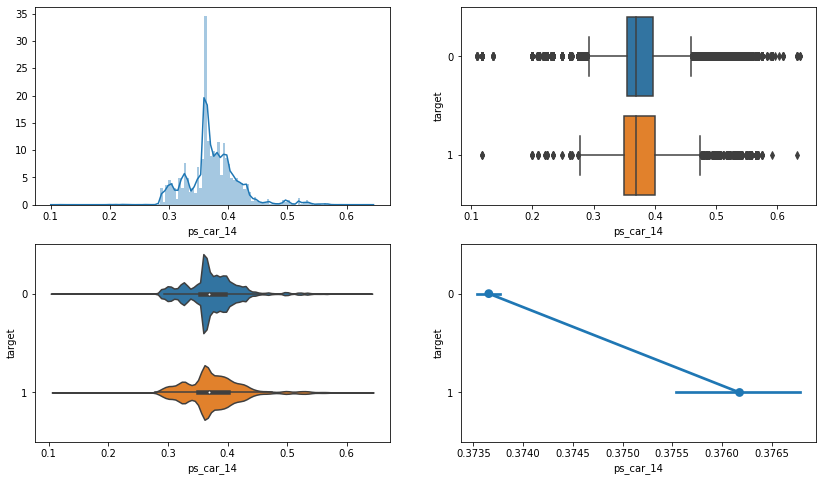

In [65]:
fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['ps_car_14'],bins=120,ax=ax1)
sns.boxplot(x='ps_car_14',y='target',data=train,ax=ax2)
sns.violinplot(x='ps_car_14',y='target',data=train,ax=ax3)
sns.pointplot(x='ps_car_14',y='target',data=train,ax=ax4)

## Descrictive Statistic Features

In [66]:
def descrictive_stat_feat(df):
    df = pd.DataFrame(df)
    dcol= [c for c in train.columns if train[c].nunique()>=10]
    dcol.remove('id')   
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 10 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df

In [67]:
train = descrictive_stat_feat(train)
test = descrictive_stat_feat(test)

## Correlation plot

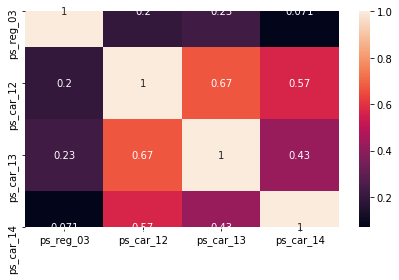

In [68]:
cor = train[num_col].corr()
plt.figure()
sns.heatmap(cor,annot=True)
plt.tight_layout()

## Determine outliers in dataset

In [69]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
                
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
outlier(train,num_col)
outlier(test,num_col) 


ps_reg_03 0.08484029175000007 1.54909582495 0.4183300133000001 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.31788087655 1.2591761161500001 0.44830050977400004 1.6176168955090011
ps_car_14 0.2891566484999999 0.4608812941000002 0.2887905816 0.5234500931
ps_reg_03 0.08156262285000004 1.55455860645 0.41907636539999993 1.8521946442
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.3188870638624999 1.2584782365625 0.4485283558 1.6172399231399996
ps_car_14 0.2891566484999999 0.4608812941000002 0.2887905816 0.5234500931


/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## One Hot Encoding

In [70]:
def OHE(df1,df2,column):
    cat_col = column
    #cat_col = df.select_dtypes(include =['category']).columns
    len_df1 = df1.shape[0]
    
    df = pd.concat([df1,df2],ignore_index=True)
    c2,c3 = [],{}
    
    print('Categorical feature',len(column))
    for c in cat_col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df, prefix=c3, columns=c2,drop_first=True)

    df1 = df.loc[:len_df1-1]
    df2 = df.loc[len_df1:]
    print('Train',df1.shape)
    print('Test',df2.shape)
    return df1,df2

In [71]:
train1,test1 = OHE(train,test,tot_cat_col)

/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Categorical feature 32
Train (595212, 200)
Test (892816, 200)


## Split data set

In [72]:
X = train1.drop(['target','id'],axis=1)
y = train1['target'].astype('category')
x_test = test1.drop(['target','id'],axis=1)
del train1,test1

## Hyperparameter tuning

In [73]:
#Grid search
"""logreg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=3)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C'])) """

"logreg = LogisticRegression(class_weight='balanced')\nparam = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1]}\nclf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=3)\nclf.fit(X,y)\nprint('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C'])) "

## Logistic Regression model

In [74]:
kf = StratifiedKFold(n_splits=5,random_state=seed,shuffle=True)
pred_test_full=0
cv_score=[]
i=1
for train_index,test_index in kf.split(X,y):    
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    lr = LogisticRegression(class_weight='balanced',C=0.003)
    lr.fit(xtr, ytr)
    pred_test = lr.predict_proba(xvl)[:,1]
    score = roc_auc_score(yvl,pred_test)
    print('roc_auc_score',score)
    cv_score.append(score)
    pred_test_full += lr.predict_proba(x_test)[:,1]
    i+=1



1 of kfold 5


/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


roc_auc_score 0.6331828885513866

2 of kfold 5


/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


roc_auc_score 0.636021195037364

3 of kfold 5


/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


roc_auc_score 0.636046519496651

4 of kfold 5


/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


roc_auc_score 0.6339801505905056

5 of kfold 5


/Users/d_ando/gizumo/pipenv/.venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


roc_auc_score 0.6372739005585525


## Moel Performane

In [75]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[70915 43788]
 [ 1832  2506]]
Cv [0.6331828885513866, 0.636021195037364, 0.636046519496651, 0.6339801505905056, 0.6372739005585525] 
Mean cv Score 0.635300930846892


## Reciever Operating Charactaristics

Text(0.5, 0, 'False positive rate')

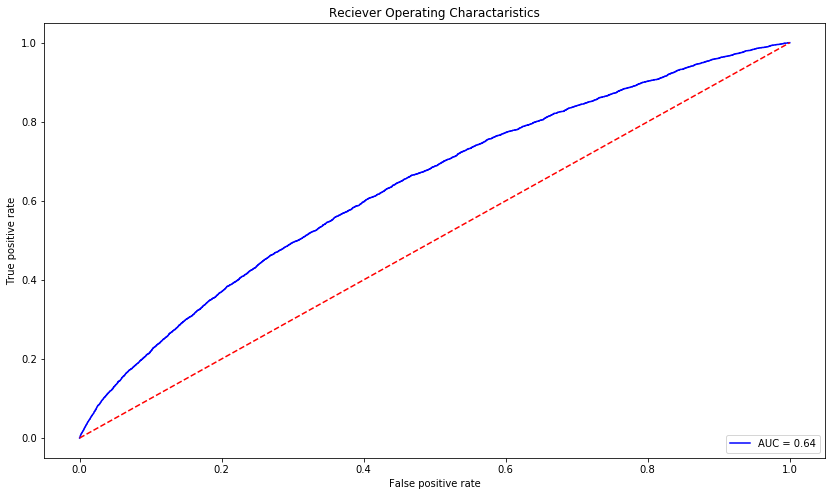

In [76]:
proba = lr.predict_proba(xvl)[:,1]
fpr,tpr, threshold = roc_curve(yvl,proba)
auc_val = auc(fpr,tpr)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

## Predict for unseen data set

In [77]:
y_pred = pred_test_full/5
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
#submit.to_csv('lr_porto.csv.gz',index=False,compression='gzip') 
# submit.to_csv('lr_porto.csv',index=False) 


In [78]:
submit.head()

,id,target
0,0,0.403880
1,1,0.475061
2,2,0.396637
3,3,0.298937
4,4,0.473485


In [79]:
# submit.to_csv('csv/lr_porto.csv', index=False) 

In [80]:
submit.to_csv('csv/lr_porto2.csv.gz',index=False,compression='gzip') 